In [1]:
using CUDA
using Plots
using FFTW
using AbstractFFTs
using Pkg
using Adapt
using LinearAlgebra
using LaTeXStrings
gr()

Plots.GRBackend()

In [2]:
Pkg.develop(path="C:/Users/hayde/Desktop/University_of_Southampton_files/2024-2025_Summer_research/GPU_CFD_solver/kolomogorov_GPU_mask/kGPU_M")

   Resolving package versions...
  No Changes to `C:\Users\hayde\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\hayde\.julia\environments\v1.11\Manifest.toml`


In [3]:
import kGPU_M

[ Info: Precompiling kGPU_M [871f8503-faad-444c-96ba-fcb079632f97] (cache misses: include_dependency fsize change (8), mismatched flags (12))


In [4]:
dt = 0.01
Re = 10.0
max_iter = 20000;

x_len = 150
y_len = 150

x_cutoff = 100;
y_cutoff = 100;

xs_full = LinRange(0, 2pi, x_len+1);
ys_full = LinRange(0, 2pi, y_len+1);

xs = Array(xs_full[1:x_len]);
ys = Array(ys_full[1:y_len]);

ω0 = [cos(x) + cos(y) for x in xs, y in ys];

source = Array(repeat([0.0], x_len, y_len));
source_hat = rfft(source);

forcing_freq = 1;

In [5]:
solver_GPU = kGPU_M.solver{CuArray, kGPU_M.GPU_rfft_type64, kGPU_M.GPU_irfft_type64}()
kGPU_M.init_solver(solver_GPU, dt, Re, max_iter, xs, ys, x_cutoff, y_cutoff, ω0, source_hat, forcing_freq);

In [6]:
kGPU_M.run(solver_GPU, max_iter)

In [7]:
solver_CPU = Adapt.adapt_structure(Array, solver_GPU);

In [8]:
ω_arr = kGPU_M.calc_physical_data(solver_CPU);

150×150×20000 Array{Float64, 3}:
[:, :, 1] =
 1.998    1.99712  1.9945   1.99012  …  1.98401  1.99012  1.9945   1.99712
 1.99712  1.99625  1.99362  1.98925     1.98313  1.98925  1.99362  1.99625
 1.9945   1.99362  1.99099  1.98662     1.98051  1.98662  1.99099  1.99362
 1.99012  1.98925  1.98662  1.98225     1.97613  1.98225  1.98662  1.98925
 1.98401  1.98313  1.98051  1.97613     1.97002  1.97613  1.98051  1.98313
 1.97617  1.97529  1.97267  1.96829  …  1.96218  1.96829  1.97267  1.97529
 1.96662  1.96574  1.96311  1.95874     1.95263  1.95874  1.96311  1.96574
 1.95536  1.95449  1.95186  1.94749     1.94137  1.94749  1.95186  1.95449
 1.94243  1.94156  1.93893  1.93456     1.92844  1.93456  1.93893  1.94156
 1.92785  1.92697  1.92434  1.91997     1.91386  1.91997  1.92434  1.92697
 1.91163  1.91076  1.90813  1.90376  …  1.89764  1.90376  1.90813  1.91076
 1.89382  1.89294  1.89031  1.88594     1.87983  1.88594  1.89031  1.89294
 1.87443  1.87356  1.87093  1.86655     1.86044  1.8665

In [9]:
min1 = minimum(ω_arr);
max1 = maximum(ω_arr);

levels1 = LinRange(min1, max1, 25);

In [11]:
print_times = [1.0, 15.0, 80.0]
iter_times = Array{Int64}(print_times * 100)

3-element Vector{Int64}:
  100
 1500
 8000

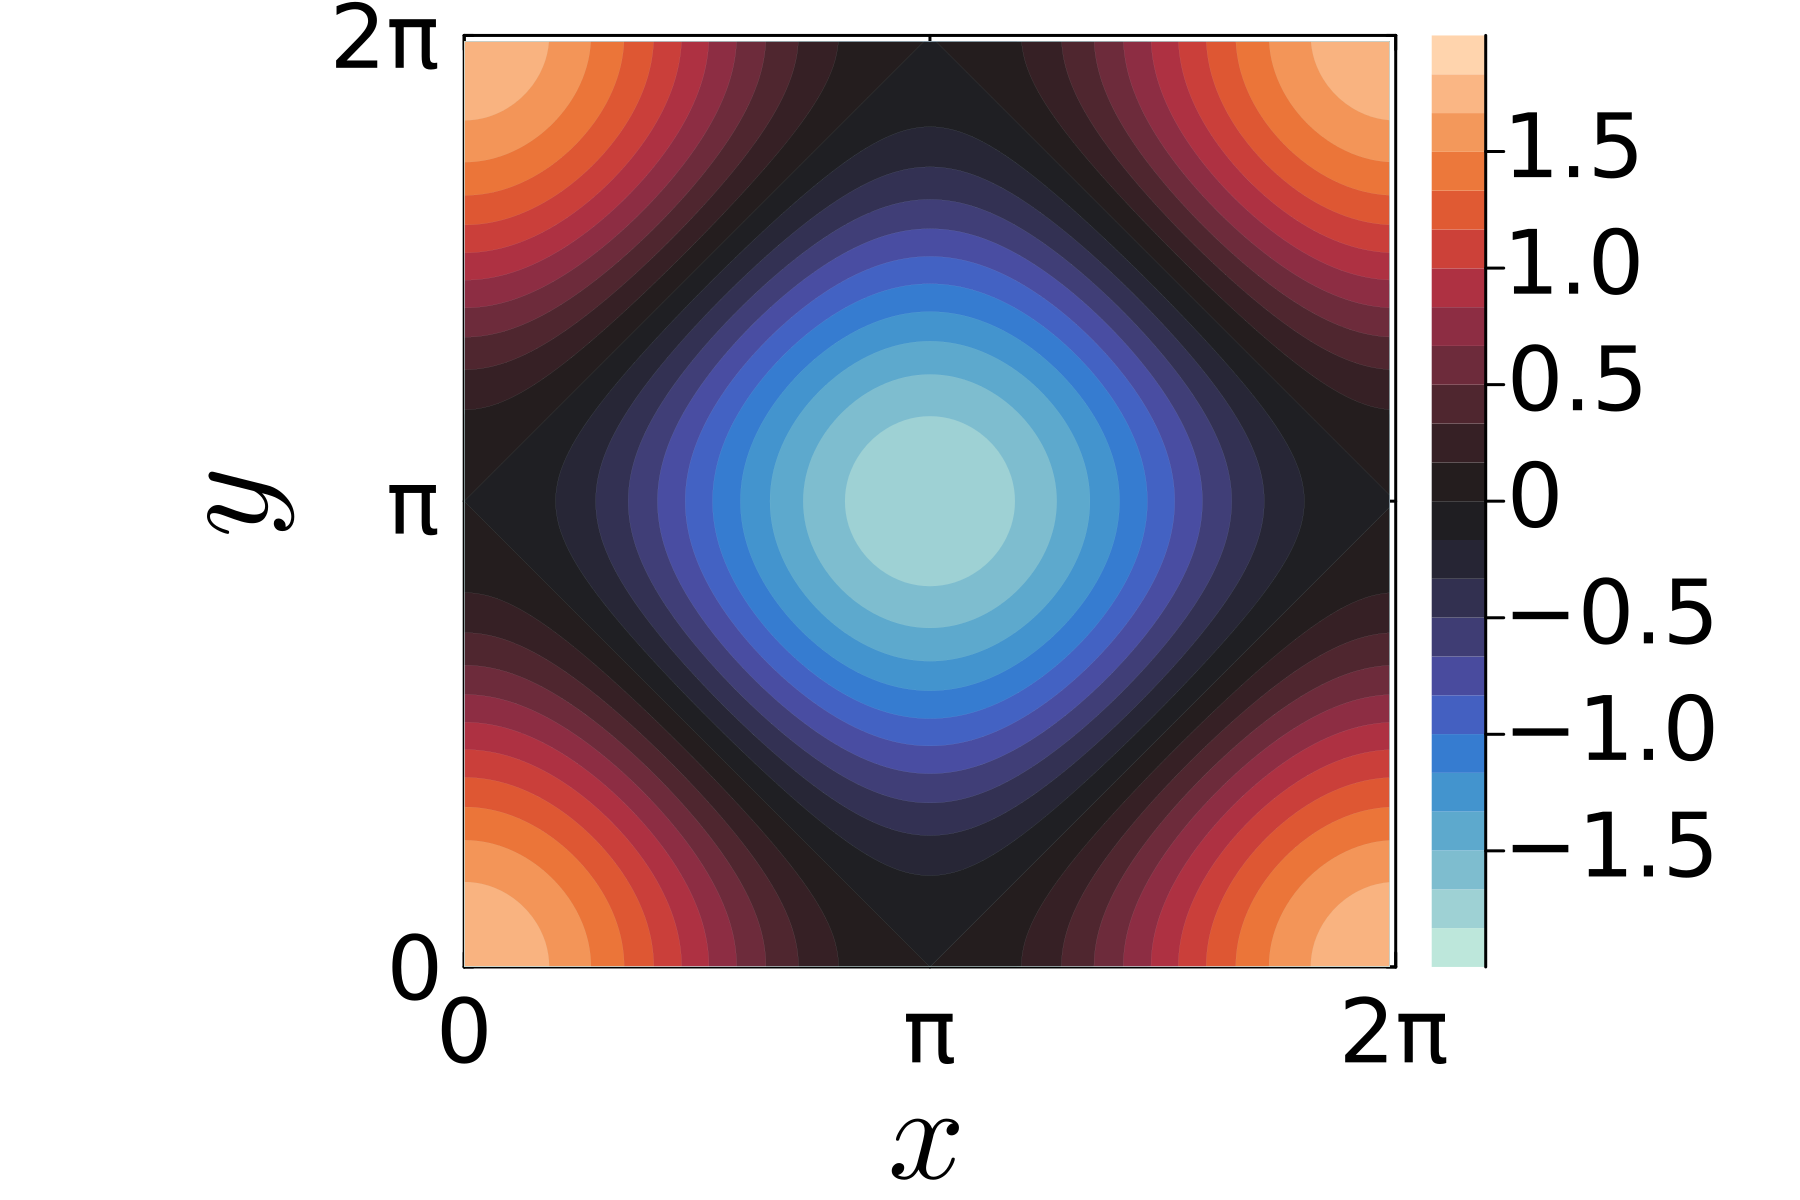

In [14]:
contourf(xs, ys, ω_arr[:, :, iter_times[1]], linewidth=0, aspect_ratio=1.0, x_ticks=([0.000001, pi, 2pi], ["0", "π", "2π"]), y_ticks=([0.000001, pi, 2pi], ["0", "π", "2π"]), levels=levels1, cbar_lims=(min1, max1), 
        framestyle=:box, c=:seaborn_icefire_gradient, xlimits=(0, 2pi), ylimits=(0, 2pi), dpi=300, xlabel=L"$x$", ylabel=L"$y$", xtickfontsize=20, xguidefontsize=30, ytickfontsize=20, yguidefontsize=30)
#savefig("TGV_solver_t1.0.png")

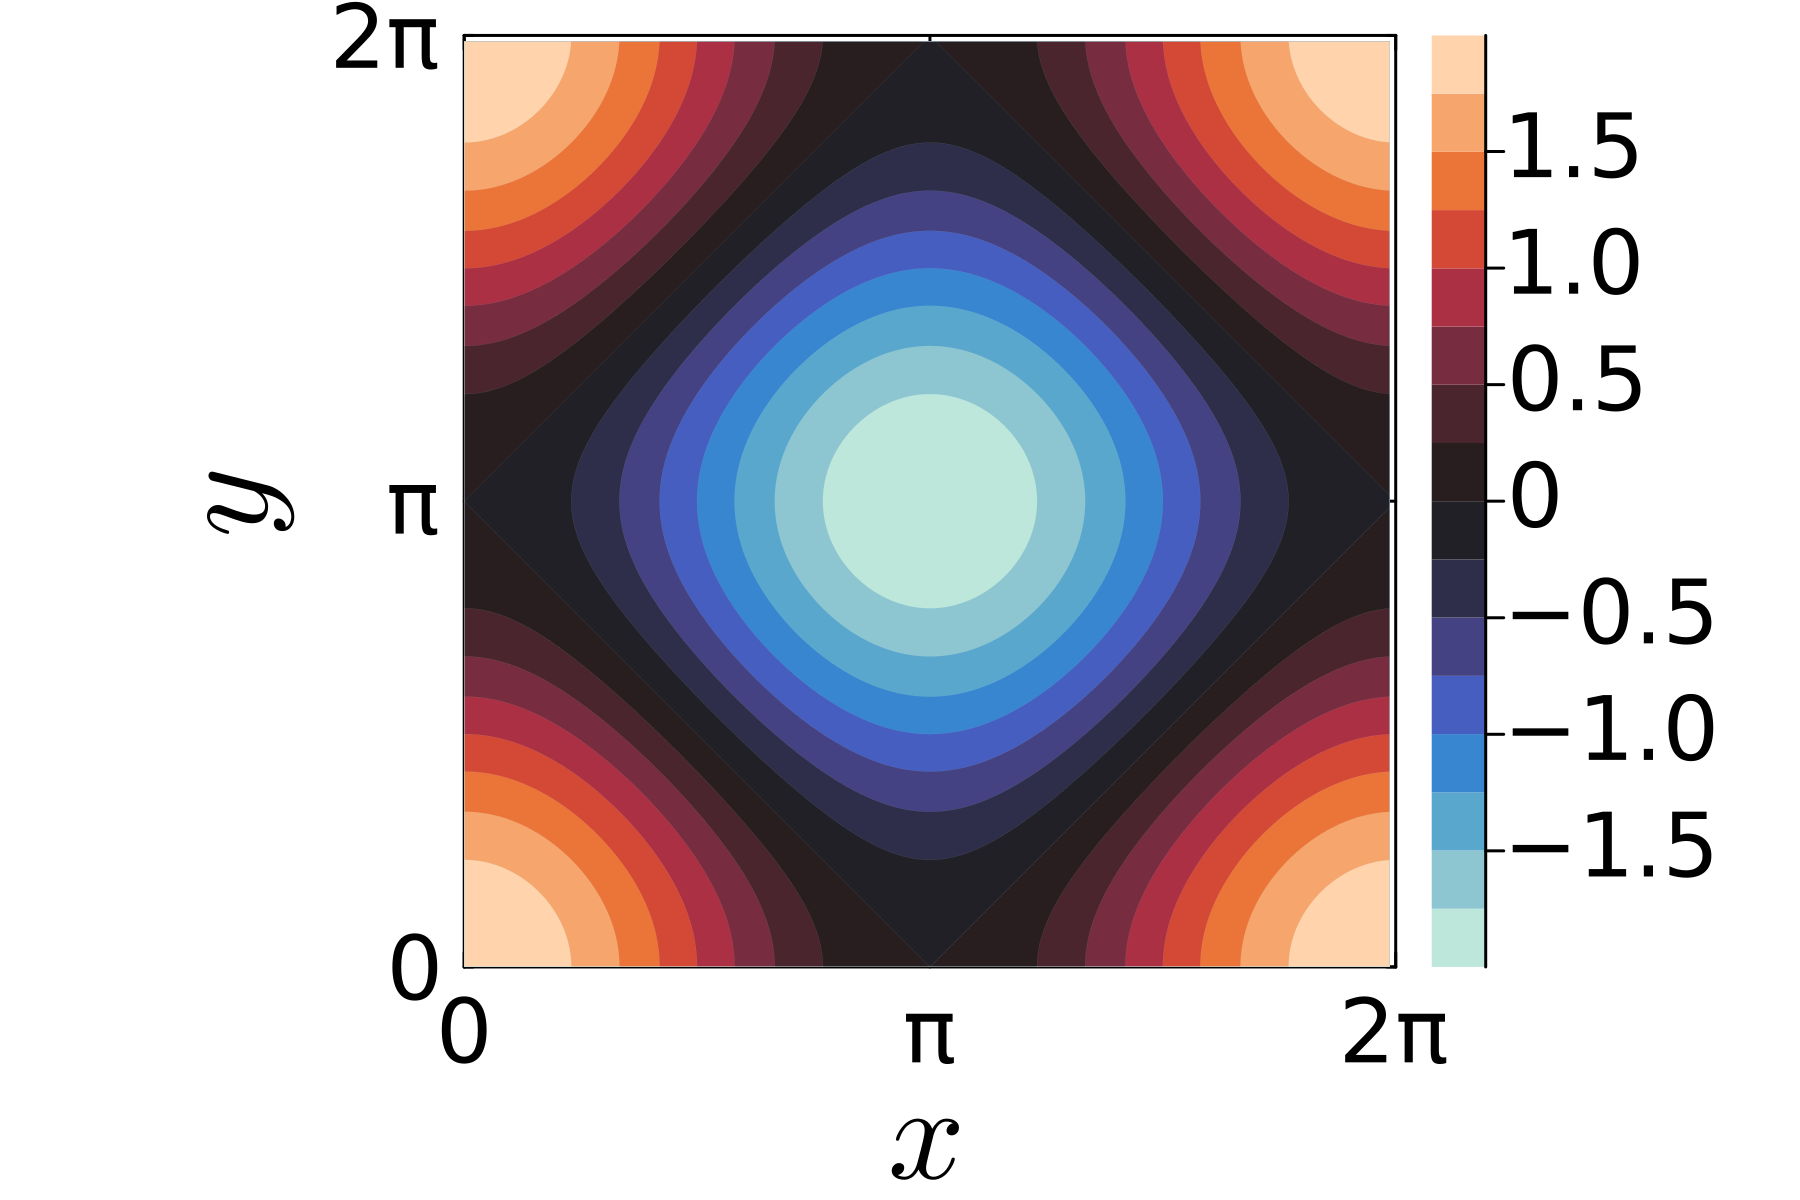

In [15]:
contourf(xs, ys, ω_arr[:, :, 1], linewidth=0, aspect_ratio=1.0, x_ticks=([0.000001, pi, 2pi], ["0", "π", "2π"]), y_ticks=([0.000001, pi, 2pi], ["0", "π", "2π"]), 
    cbar_lims=(min1, max1), framestyle=:box, c=:seaborn_icefire_gradient, xlimits=(0, 2pi), ylimits=(0, 2pi), dpi=300, xlabel=L"$x$", ylabel=L"$y$", xtickfontsize=20, xguidefontsize=30, ytickfontsize=20, yguidefontsize=30)


In [16]:
for i in 1:size(print_times, 1)
    contourf(xs, ys, ω_arr[:, :, iter_times[i]], linewidth=0, aspect_ratio=1.0, x_ticks=([0.000001, pi, 2pi], ["0", "π", "2π"]), y_ticks=([0.000001, pi, 2pi], ["0", "π", "2π"]), levels=levels1, cbar_lims=(min1, max1), 
            framestyle=:box, c=:seaborn_icefire_gradient, xlimits=(0, 2pi), ylimits=(0, 2pi), dpi=300, xlabel=L"$x$", ylabel=L"$y$", xtickfontsize=20, xguidefontsize=30, ytickfontsize=20, yguidefontsize=30)
    #savefig("TGV_solver_t$(print_times[i]).png")
end;

In [16]:
# validation case

nu = 1 / 10 #pi / 5

function ω_TGV(x, y, t)
    return(cos(x) + cos(y)) * exp(-nu * t)# * 1 / (2pi)
end;

In [17]:
t_total = dt * max_iter;
t_arr = round.(Array(LinRange(dt, t_total, max_iter)), digits=2);

In [18]:
ω_arr_TGV = [ω_TGV(x, y, t) for x in xs, y in ys, t in t_arr];

In [19]:
for i in 1:size(print_times, 1)
    contourf(xs, ys, ω_arr_TGV[:, :, iter_times[i]], cbar_lims=(min1, max1), levels=levels1, linewidth=0, aspect_ratio=1.0, x_ticks=([0.0, pi, 2pi], ["0", "π", "2π"]), y_ticks=([0.0, pi, 2pi], ["0", "π", "2π"]),
            framestyle=:box, c=:seaborn_icefire_gradient, xlimits=(0, 2pi), ylimits=(0, 2pi), dpi=300, xlabel=L"$x$", ylabel=L"$y$", xtickfontsize=20, xguidefontsize=30, ytickfontsize=20, yguidefontsize=30)
    #savefig("TGV_solution_t$(print_times[i]).png")
end;

In [ ]:
abs_err_arr = repeat([0.0], max_iter);
rel_err_arr = repeat([0.0], max_iter);

for i in 1:size(rel_err_arr, 1)
    abs_err_arr[i] = norm(ω_arr_TGV[:, :, i] - ω_arr[:, :, i])
    rel_err_arr[i] = abs_err_arr[i] / norm(ω_arr_TGV[:, :, i])
end;



In [ ]:
minimum(rel_err_arr)

In [ ]:
plot(t_arr, rel_err_arr, label="Relative error", xlabel=L"\textsf{Time}", ylabel=L"\textsf{Relative\ error\ magnitude}", dpi=300, ylimits=(5e-11, 1e-5), yscale=:log10)
#savefig("TGV_solver_rel_err.png")

In [100]:
norm(ω_arr_TGV[:, :, 10000])

0.006809989464372727

In [102]:
norm(ω_arr[:, :, 10000])

0.006809983789383377

In [90]:
norm(ω_arr_TGV[:, :, 100] .- ω_arr[:, :, 100])

0.1357946291852037

In [93]:
norm(ω_arr_TGV[:, :, 100] .- ω_arr[:, :, 98])

0.13592824891088512